# E2a: Küchentischversuch zum Laval-Rotor

Name:  Young-Min Kong
Datum:  22.12.2023

## Forschungsfrage

Wie beeinflussen verschiedene Vibrationen die gemessenen Beschleunigungsdaten, und inwieweit können diese Informationen für Anwendungen wie Maschinenüberwachung oder Gestensteuerung genutzt werden?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="images/smartphone.jpg" width="500">

- Materialien:
    - Raspberry Pi
    - Beschleunigungssensor
    - Klebeband oder Befestigungsmaterial
    - Smartphone
    - Jumperkabel für die Verbindung zwischen dem Sensor und dem Raspberry Pi
- Beschreibung des Aufbaus:
Der Beschleunigungssensor wird am Smartphone mithilfe eines Klebebands befestigt. Der Sensor ist über die Jumperkabel an den entsprechenden GPIO Pins des Raspberry Pis angeschlossen. 
- Vorgangsbeschreibung:
Es wird im Raspberry Pi ein Programm für die Erfassung der Sensordaten geschrieben. Der Smartphone wird zum Vibrieren gebracht und die Beschleunigungsdaten werden in einem Datenbank mithilfe des Programms geschrieben. 


## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [1]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [2]:
"""Parameter definition"""
path_measurement_folder = "measurement_data/data_20231222_181226_Young-Min_Kong_smartphone"
h5_file_name = "data_20231222_181226_Young-Min_Kong_smartphone.h5"

In [3]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20231222_181226_Young-Min_Kong_smartphone/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20231222_181226_Young-Min_Kong_smartphone/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20231222_181226_Young-Min_Kong_smartphone/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eea0e47-d13a-6459-9f84-bb949e26e89a": {
    "type": "probe",
    "name": "smartphone",
    "comment": "",
    "path"

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [4]:
h5_path = path_measurement_folder + "/" + h5_file_name
f = h5py.File(h5_path, 'r')
dset_all = f['RawData']['1ee847be-fddd-6ee4-892a-68c4555b0981']
acc_x = dset_all['acceleration_x'][()]
acc_y = dset_all['acceleration_y'][()]
acc_z = dset_all['acceleration_z'][()]
vec_time = dset_all['timestamp'][()]

#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [5]:
acc_abs = get_vec_accel(acc_x, acc_y, acc_z)

#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


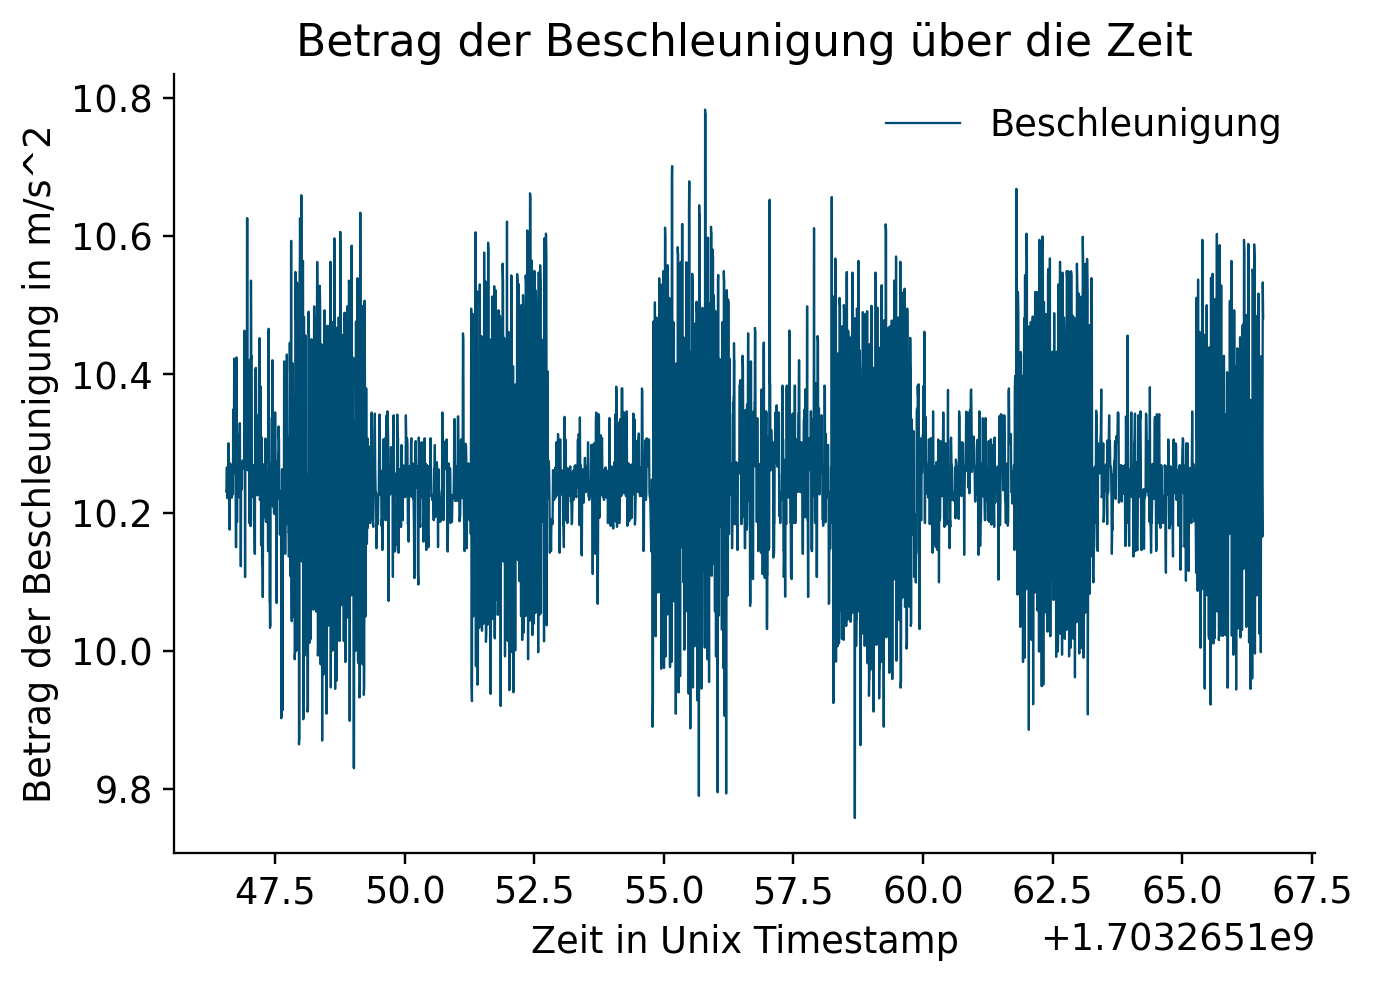

In [6]:
# Plot für den Betrag der Beschleunigung über die Zeit
plt.plot(vec_time, acc_abs, label='Beschleunigung')
plt.xlabel('Zeit in Unix Timestamp')
plt.ylabel('Betrag der Beschleunigung in m/s^2')
plt.title('Betrag der Beschleunigung über die Zeit')
plt.legend()

# Zeigen Sie den Plot an
plt.show()

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [7]:
# -------------------------------------------------------------------------------------------#4-start
time_interp, acc_interp = interpolation(vec_time, acc_abs)

#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

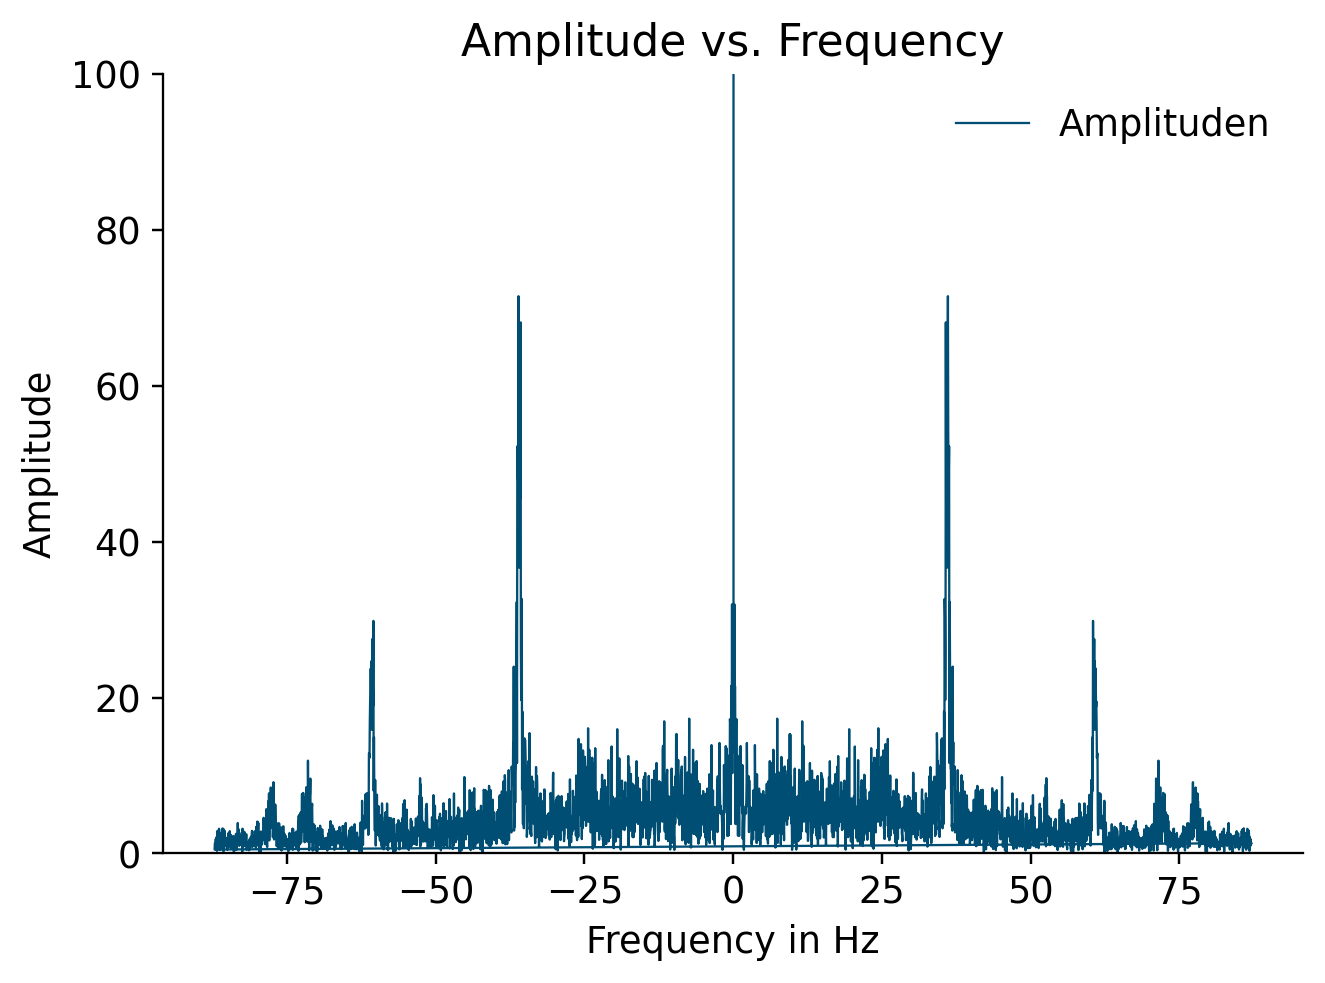

In [21]:
# -------------------------------------------------------------------------------------------#5-start
amplitude, frequencies = my_fft(acc_interp, time_interp)
# Plot für den Betrag der Beschleunigung über die Zeit
plt.plot(frequencies, amplitude, label='Amplituden')
plt.xlabel('Frequency in Hz')
plt.ylabel('Amplitude')
plt.title('Amplitude vs. Frequency')
plt.legend()

# Zeigen Sie den Plot an
plt.ylim(0,100)
plt.show()

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="images/speaker.jpg" width="500">

- Materialien:
    - Raspberry Pi
    - Beschleunigungssensor
    - Klebeband oder Befestigungsmaterial
    - Lautsprecher
    - Jumperkabel für die Verbindung zwischen dem Sensor und dem Raspberry Pi
- Beschreibung des Aufbaus:
Der Beschleunigungssensor wird am Lautsprecher mithilfe eines Klebebands befestigt. Der Sensor ist über die Jumperkabel an den entsprechenden GPIO Pins des Raspberry Pis angeschlossen. 
- Vorgangsbeschreibung:
Es wird im Raspberry Pi ein Programm für die Erfassung der Sensordaten geschrieben. Der Smartphone wird zum Vibrieren gebracht und die Beschleunigungsdaten werden in einem Datenbank mithilfe des Programms geschrieben. 

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [17]:
"""Parameter definition"""
path_measurement_folder = "measurement_data/data_20231222_182954_Young-Min_Kong_speaker"
h5_file_name = "data_20231222_182954_Young-Min_Kong_speaker.h5"
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20231222_182954_Young-Min_Kong_speaker/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20231222_182954_Young-Min_Kong_speaker/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20231222_182954_Young-Min_Kong_speaker/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eea0ef0-00e1-68fe-9a53-469f6a0eb3c2": {
    "type": "probe",
    "name": "speaker",
    "comment": "",
    "path": "measureme

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [18]:
h5_path = path_measurement_folder + "/" + h5_file_name
f = h5py.File(h5_path, 'r')
dset_all = f['RawData']['1ee847be-fddd-6ee4-892a-68c4555b0981']
acc_x = dset_all['acceleration_x'][()]
acc_y = dset_all['acceleration_y'][()]
acc_z = dset_all['acceleration_z'][()]
vec_time = dset_all['timestamp'][()]

#### 2. Betrag der Beschleunigung berechnen


In [19]:
acc_abs = get_vec_accel(acc_x, acc_y, acc_z)

#### 3. Darstellung der Messdaten

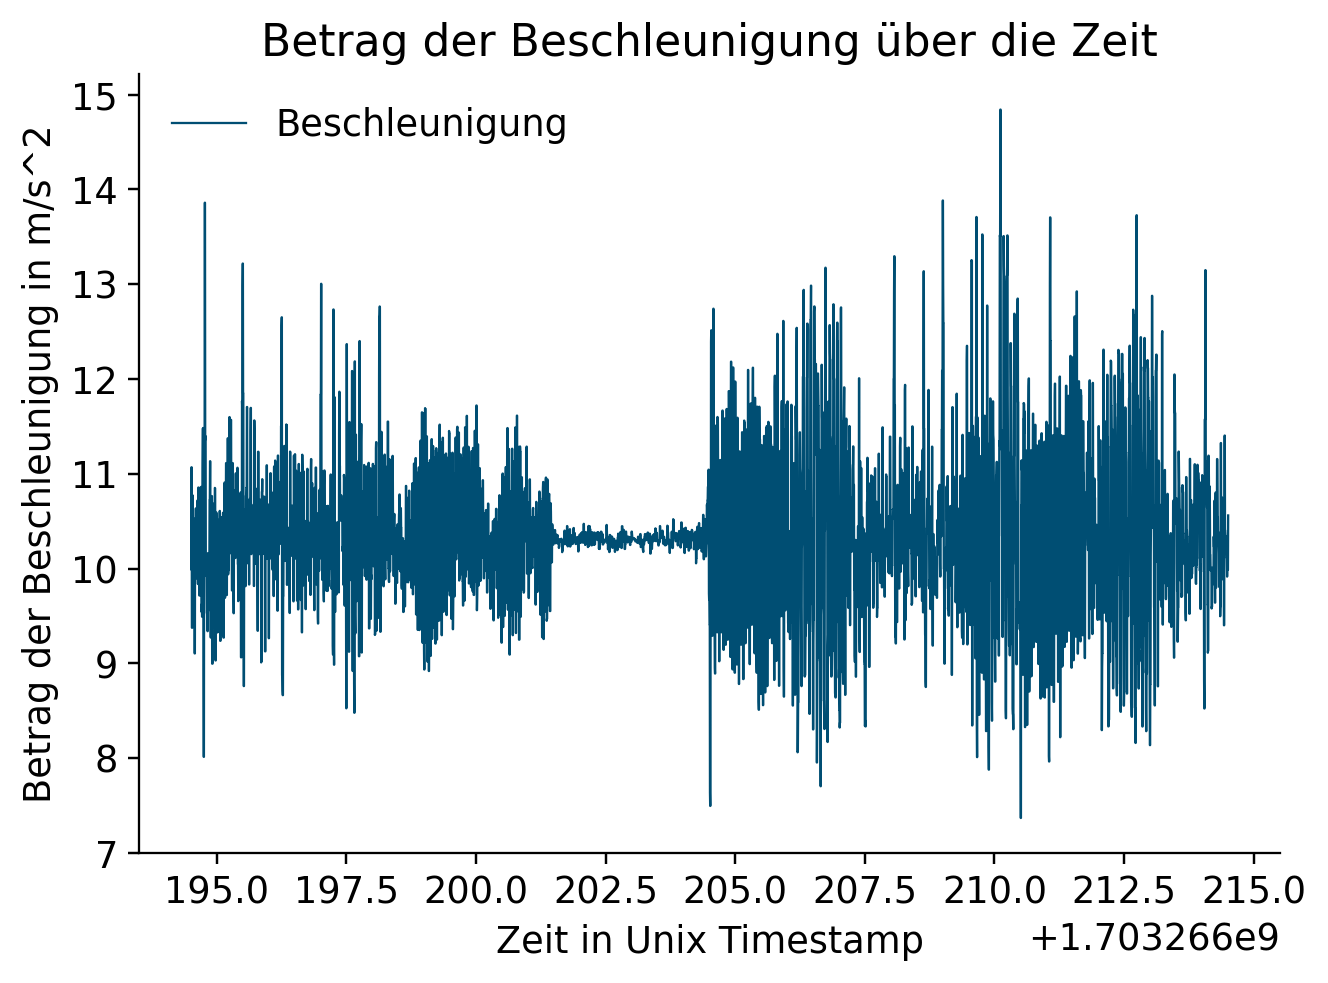

In [20]:
# Plot für den Betrag der Beschleunigung über die Zeit
plt.plot(vec_time, acc_abs, label='Beschleunigung')
plt.xlabel('Zeit in Unix Timestamp')
plt.ylabel('Betrag der Beschleunigung in m/s^2')
plt.title('Betrag der Beschleunigung über die Zeit')
plt.legend()

# Zeigen Sie den Plot an
plt.show()

#### 4. Interpolation der Messwerte



In [22]:
# -------------------------------------------------------------------------------------------#4-start
time_interp, acc_interp = interpolation(vec_time, acc_abs)

#### 5 & 6. FFT durchführen und graphisch darstellen


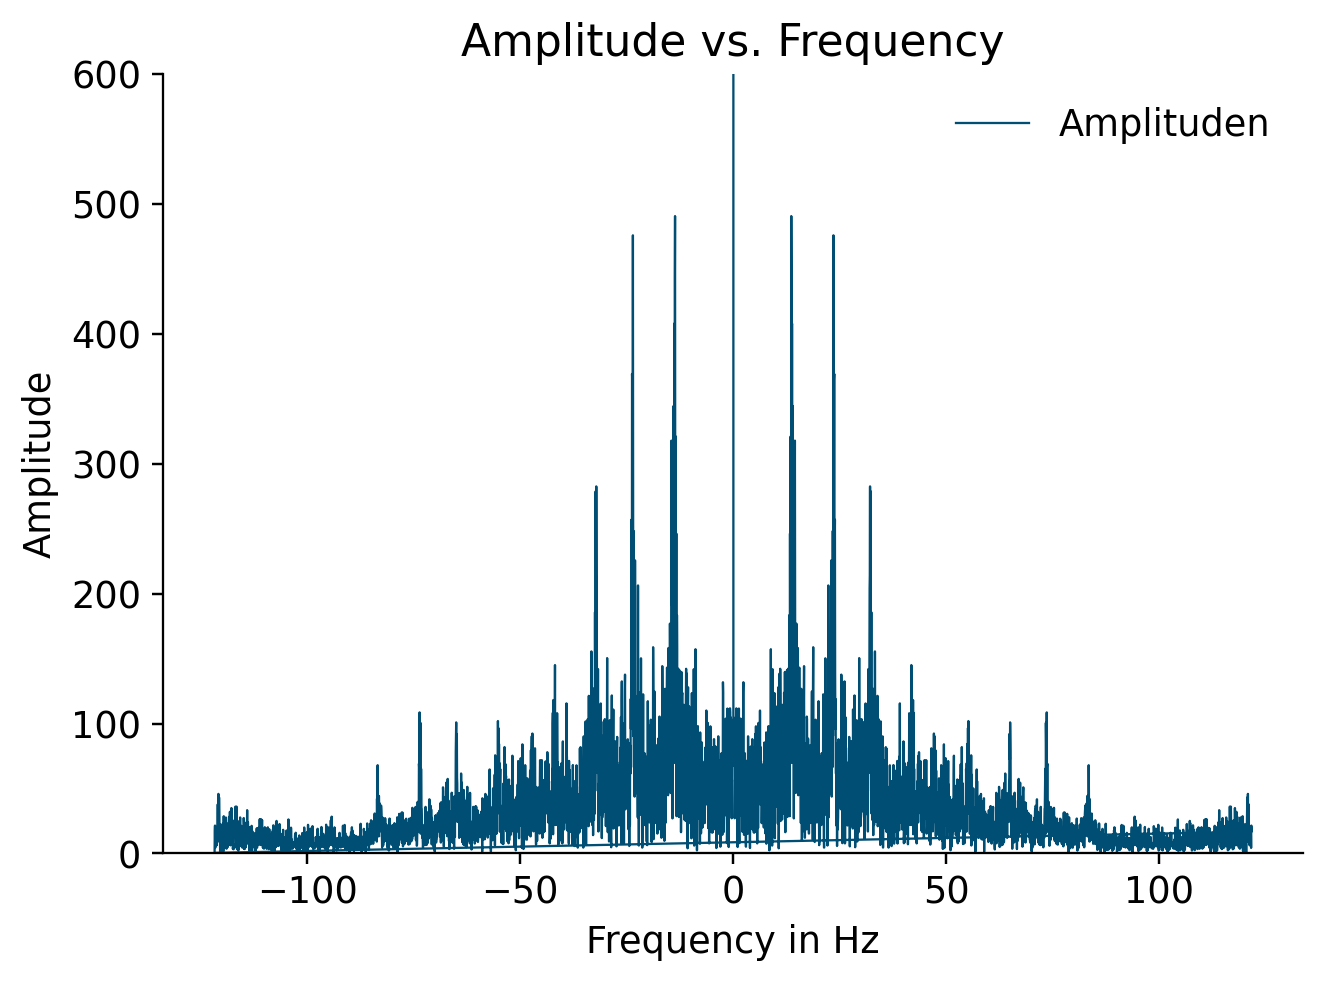

In [26]:
# -------------------------------------------------------------------------------------------#5-start
amplitude, frequencies = my_fft(acc_interp, time_interp)
# Plot für den Betrag der Beschleunigung über die Zeit
plt.plot(frequencies, amplitude, label='Amplituden')
plt.xlabel('Frequency in Hz')
plt.ylabel('Amplitude')
plt.title('Amplitude vs. Frequency')
plt.legend()

# Zeigen Sie den Plot an
plt.ylim(0,600)
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Die Experimente zeigen, dass unterschiedliche Vibrationsmuster signifikante Variationen in den gemessenen Beschleunigungsdaten verursachen. Dies deutet darauf hin, dass die Charakterisierung von Vibrationsmustern in Anwendungen wie Maschinenüberwachung oder Gestensteuerung relevant sein könnte. Allerdings sind unsere Ergebnisse durch Umgebungsvariablen und die Notwendigkeit weiterer Forschung für die Generalisierbarkeit eingeschränkt. Trotzdem bieten sie einen vielversprechenden Ansatzpunkt für zukünftige Studien im Bereich der Anwendung von Vibrationsdaten in der Technologie.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Der durchgeführte Versuch lieferte aufschlussreiche Einblicke in die Auswirkungen von Vibrationsmustern auf Beschleunigungsdaten. Persönlich habe ich viel über die praktische Anwendung von Sensoren und Raspberry Pi gelernt. Die vielseitige Anwendbarkeit dieser Erkenntnisse in verschiedenen technologischen Bereichen motiviert mich, mein Verständnis in diesem Bereich weiter zu vertiefen.